In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyslim, tskit
import itertools
import scipy.special
import os, subprocess, sys
from Bio import Phylo
from io import StringIO
import msprime
import tqdm
from pathlib import Path
import statsmodels.stats.proportion
import glob
import joblib
import seaborn as sns

sys.path.append(str(Path(os.getcwd()).parent))

In [3]:
from src import extract_tree_stats, curve_inference, estimators, loader, tests

In [40]:
os.environ['R_HOME'] = "/home/rs2145/rs2145/software/anaconda3/envs/dated_selection/lib/R"

In [41]:
%load_ext rpy2.ipython

# Pick three regimes

In [77]:
filenames_neutral = glob.glob(
    f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs=-3.0/logNUd=2/seed=*/output.trees.tsz"
)

filenames_bgs = glob.glob(
    f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs=2.0/logNUd=2/seed=*/output.trees.tsz"
)

filenames_interference = glob.glob(
    f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs=1.0/logNUd=2/seed=*/output.trees.tsz"
)


# Draw trees

# Draw mutation rate declines

In [4]:
def get_mutation_counts_and_lineages_for_ts(
    filename, 
    max_generations, 
    sample_times, 
    sample_sizes,
    n_bins,
    neutral_mutation_rate_per_genome = 0,
):
    sts = loader.load_tree_sequence_from_slim(filename, sample_sizes, sample_times, neutral_mutation_rate_per_genome) 
    
    mutation_times = []
    mutation_weights = []
    for variant in sts.variants():
        for mutation in variant.site.mutations:
            mutation_times.append(mutation.time)
            mutation_weights.append(sts.num_samples - variant.counts()[''])
    
    hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
    mut_counts_per_bin = np.histogram(mutation_times, bins=hist_bins, weights=mutation_weights)[0]

    n_lineages = np.zeros(max_generations, dtype=int)
    for sample_time, sample_size in zip(sample_times, sample_sizes):
        n_lineages[sample_time:] += sample_size
    n_lineages_per_bin = n_lineages.reshape((n_bins, -1)).sum(axis=1)
    
    return mut_counts_per_bin, n_lineages_per_bin
    

In [10]:
def extract_mutation_rates_from_filenames(filenames):
    n_bins = 4000
    max_generations = 4000
    hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
    all_res = joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(get_mutation_counts_and_lineages_for_ts)(filename, max_generations, [0], [1000], n_bins, 0) \
               for filename in filenames
    )

    mut_counts_per_bin, n_lineages_per_bin = np.array(all_res).sum(axis=0)
    mutation_rate_est = mut_counts_per_bin / n_lineages_per_bin

    times = hist_bins[:-1]

    return times, mutation_rate_est

In [12]:
def effective_mutation_rate_theory(t, Ud, s):
    return Ud * np.exp(-s * t)

### Draw neutral

In [27]:
%%time
times_neut, mutation_rate_est_neut = extract_mutation_rates_from_filenames(filenames_neutral)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:    6.6s remaining:   40.6s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    7.7s remaining:   22.0s
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    9.2s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   12.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   12.8s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   13.8s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   14.5s remaining:    2.4s


CPU times: user 114 ms, sys: 23.4 ms, total: 138 ms
Wall time: 15.2 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.2s finished


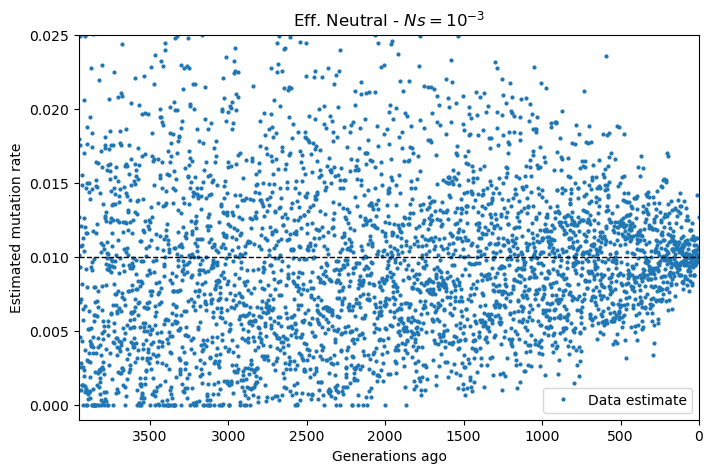

In [72]:

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_neut, mutation_rate_est_neut, '.', ms=4, label="Data estimate");
ax.axhline(0.01, ls='--', lw=1, color="black")
ax.set_xlim(-1,4000-50)
ax.set_ylim(-0.001, 0.025)
ax.set_xlabel("Generations ago")
ax.set_ylabel(r"Estimated mutation rate")
ax.legend()
ax.invert_xaxis()
ax.set_title("Eff. Neutral - $Ns = 10^{-3}$");


### Draw BGS

In [62]:
%%time
times_bgs, mutation_rate_est_bgs = extract_mutation_rates_from_filenames(filenames_bgs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:   20.1s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:   20.3s remaining:   57.8s
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:   20.4s remaining:   33.2s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   21.5s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   21.6s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   21.9s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   24.7s remaining:    4.0s


CPU times: user 234 ms, sys: 1.03 s, total: 1.27 s
Wall time: 26 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.0s finished


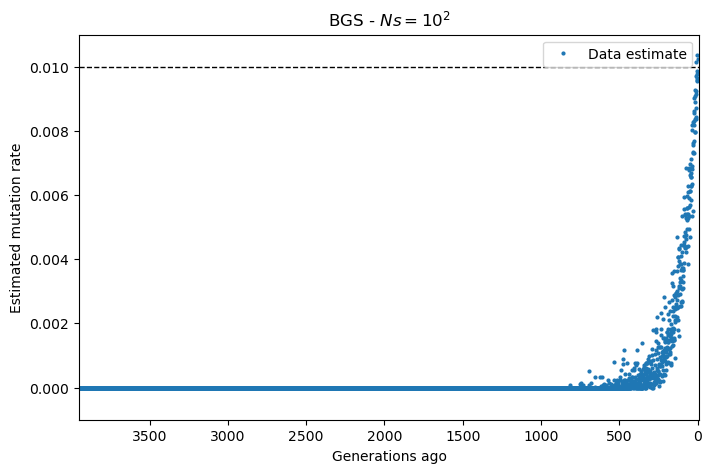

In [73]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_bgs, mutation_rate_est_bgs, '.', ms=4, label="Data estimate");
ax.axhline(0.01, ls='--', lw=1, color="black")
ax.set_xlim(-10,4000-50)
ax.set_ylim(-0.001, 0.011)
ax.set_xlabel("Generations ago")
ax.set_ylabel(r"Estimated mutation rate")
ax.legend()
ax.invert_xaxis()
ax.set_title("BGS - $Ns = 10^2}$");


### Draw interference

In [78]:
%%time
times_interference, mutation_rate_est_interference = extract_mutation_rates_from_filenames(filenames_interference)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:   10.9s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:   13.9s remaining:   39.4s
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:   14.7s remaining:   24.1s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   15.9s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   16.7s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   17.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   17.8s remaining:    2.9s


CPU times: user 135 ms, sys: 15.5 ms, total: 150 ms
Wall time: 20 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.0s finished


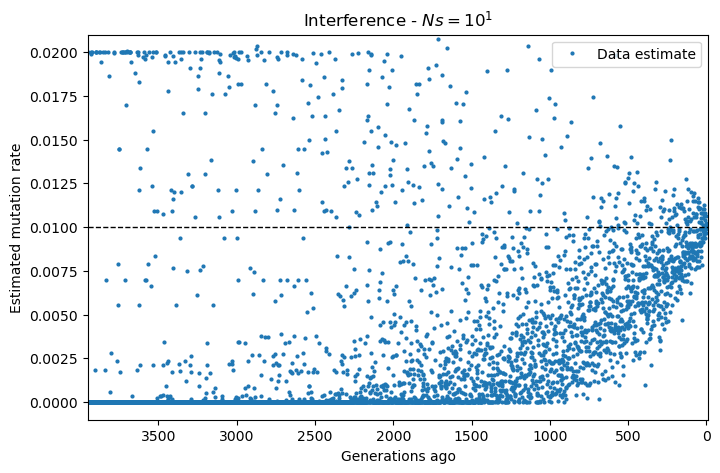

In [80]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_interference, mutation_rate_est_interference, '.', ms=4, label="Data estimate");
ax.axhline(0.01, ls='--', lw=1, color="black")
ax.set_xlim(-10,4000-50)
ax.set_ylim(-0.001, 0.021)
ax.set_xlabel("Generations ago")
ax.set_ylabel(r"Estimated mutation rate")
ax.legend()
ax.invert_xaxis()
ax.set_title("Interference - $Ns = 10^{1}$");


# Draw skyline plots

### Draw neutral

In [45]:
ts_filename = filenames_neutral[1]
newick_filename = ts_filename.replace(".trees.tsz", ".newick")

ts = loader.load_tree_sequence_from_slim(
    ts_filename,
    [100],
    [0],
    0.0,
)
T = ts.first().split_polytomies(random_seed=42)
assert len(T.roots) == 1, f"# roots = {len(T.roots)}"
with open(newick_filename, "w") as F:
    F.write(T.as_newick())

dev.new(): using pdf(file="Rplots1.pdf")


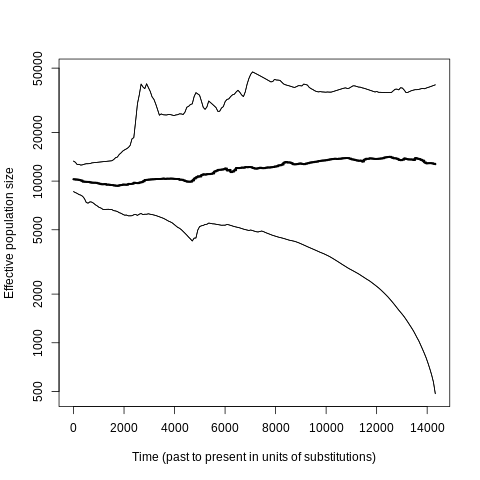

In [46]:
%%R -i newick_filename -o popsize
require("ggplot2")

# Open the conda-installed R in terminal:
# > install.packages("ape", repos='http://cran.us.r-project.org')
require("ape")

tr = read.tree(file=newick_filename)

mcmc.out <- mcmc.popsize(
    tr, 
    10000, 
    thinning=10, 
    burn.in=1000,
)

popsize <- extract.popsize(mcmc.out)

## S3 method for class 'popsize'
plot(popsize, show.median=TRUE, show.years=FALSE, subst.rate, present.year, xlab = NULL, ylab = "Effective population size")

## S3 method for class 'popsize'
lines(popsize, show.median=TRUE,show.years=FALSE, subst.rate, present.year)



### Draw BGS

In [99]:
ts_filename = filenames_bgs[6]
newick_filename = ts_filename.replace(".trees.tsz", ".newick")

ts = loader.load_tree_sequence_from_slim(
    ts_filename,
    [100],
    [0],
    0.0,
)
T = ts.first().split_polytomies(random_seed=42)
assert len(T.roots) == 1, f"# roots = {len(T.roots)}"
with open(newick_filename, "w") as F:
    F.write(T.as_newick())

dev.new(): using pdf(file="Rplots18.pdf")


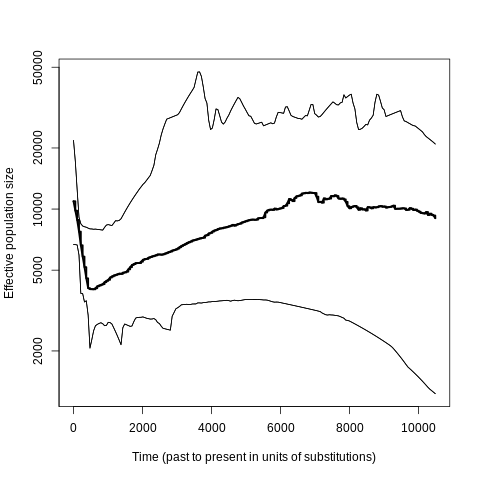

In [100]:
%%R -i newick_filename -o popsize
require("ggplot2")

# Open the conda-installed R in terminal:
# > install.packages("ape", repos='http://cran.us.r-project.org')
require("ape")

tr = read.tree(file=newick_filename)

mcmc.out <- mcmc.popsize(
    tr, 
    10000, 
    thinning=10, 
    burn.in=1000,
)

popsize <- extract.popsize(mcmc.out)

## S3 method for class 'popsize'
plot(popsize, show.median=TRUE, show.years=FALSE, subst.rate, present.year, xlab = NULL, ylab = "Effective population size")

## S3 method for class 'popsize'
lines(popsize, show.median=TRUE,show.years=FALSE, subst.rate, present.year)



### Draw interference

In [87]:
ts_filename = filenames_interference[1]
newick_filename = ts_filename.replace(".trees.tsz", ".newick")

ts = loader.load_tree_sequence_from_slim(
    ts_filename,
    [100],
    [0],
    0.0,
)
T = ts.first().split_polytomies(random_seed=42)
assert len(T.roots) == 1, f"# roots = {len(T.roots)}"
with open(newick_filename, "w") as F:
    F.write(T.as_newick())

dev.new(): using pdf(file="Rplots12.pdf")


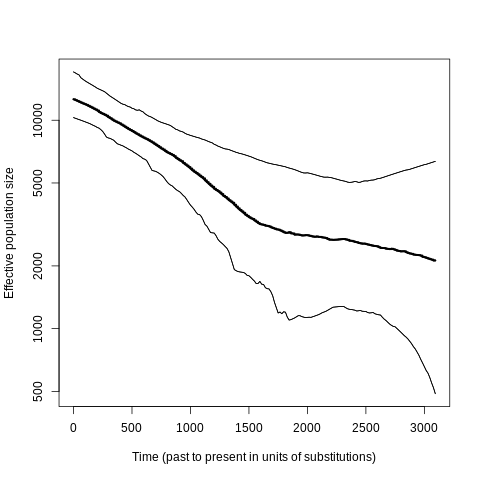

In [88]:
%%R -i newick_filename -o popsize
require("ggplot2")

# Open the conda-installed R in terminal:
# > install.packages("ape", repos='http://cran.us.r-project.org')
require("ape")

tr = read.tree(file=newick_filename)

mcmc.out <- mcmc.popsize(
    tr, 
    10000, 
    thinning=10, 
    burn.in=1000,
)

popsize <- extract.popsize(mcmc.out)

## S3 method for class 'popsize'
plot(popsize, show.median=TRUE, show.years=FALSE, subst.rate, present.year, xlab = NULL, ylab = "Effective population size")

## S3 method for class 'popsize'
lines(popsize, show.median=TRUE,show.years=FALSE, subst.rate, present.year)

